# TIF360 Project

# Data Pre-processing

Main source: https://www.kaggle.com/code/rmonge/predicting-molecule-properties-based-on-its-smiles/notebook

### Import packages

In [23]:
import os
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Define function to read xyz files

In [8]:
def read_xyz(path):
    """
    Reads the xyz files in the directory on 'path'
    Input
    path: the path to the folder to be read
    
    Output
    atoms: list with the characters representing the atoms of a molecule
    coordinates: list with the cartesian coordinates of each atom
    smile: list with the SMILE representation of a molecule
    prop: list with the scalar properties
    """
    atoms = []
    coordinates = []

    with open(path, 'r') as file:
        lines = file.readlines()
        n_atoms = int(lines[0])  # the number of atoms
        smile = lines[n_atoms + 3].split()[0]  # smiles string
        prop = lines[1].split()[2:]  # scalar properties

        # to retrieve each atmos and its cartesian coordenates
        for atom in lines[2:n_atoms + 2]:
            line = atom.split()
            # which atom
            atoms.append(line[0])

            # its coordinate
            # Some properties have '*^' indicading exponentiation 
            try:
                coordinates.append(
                    (float(line[1]),
                     float(line[2]),
                     float(line[3]))
                    )
            except:
                coordinates.append(
                    (float(line[1].replace('*^', 'e')),
                     float(line[2].replace('*^', 'e')),
                     float(line[3].replace('*^', 'e')))
                    )
                    
    return atoms, coordinates, smile, prop

#### Select which data to process:

In [9]:
read_and_write_xyz = True  # Set to 'True' if you need to generate smiles_and_targets.csv
read_and_write_morgan_fingerprints = False  # Set to 'True' if you need to generate mol_morgan_fingerprints.npy
read_and_write_rdkit_descriptors = False  # Set to 'True' if you need to generate mol_descriptors.npy
read_and_write_mordred_descriptors = False # Set to 'True' if you need to generate mordred_descriptors.npy

### Read xyz files

In [10]:
directory = '../data/dsgdb9nsd.xyz/'

properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']

if read_and_write_xyz:
    # Reads the xyz files and return the properties, smiles and coordinates
    data = []
    smiles = []
    properties = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        atoms, coordinates, smile, prop = read_xyz(path)
        data.append((atoms, coordinates)) # A tuple with the atoms and its coordinates 
        smiles.append(smile) # The SMILES representation
        properties.append(prop) # The molecules properties

    df = pd.DataFrame(properties, columns = properties_names).astype('float32')
    df['smiles'] = smiles
    df.head()

### Investigate how coordinates are specified

In [11]:
# Print cordinates of first molecule in data
if read_and_write_xyz:
    print(data[0][1])

[(-0.0126981359, 1.0858041578, 0.0080009958), (0.002150416, -0.0060313176, 0.0019761204), (1.0117308433, 1.4637511618, 0.0002765748), (-0.540815069, 1.4475266138, -0.8766437152), (-0.5238136345, 1.4379326443, 0.9063972942)]


### Draw a few of the molecules

In [12]:
if read_and_write_xyz:
    # Reading each molecule by its SMILES string
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

    # Checking if there are None values
    print("Number of NaNs: ", df['mol'].isnull().sum())

    # Reads and prints the 20 first molecules
    mol = df['mol'][:20]

    Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))

Number of NaNs:  0


### Add Hydrogens

In [13]:
if read_and_write_xyz:
    df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

### Count the number of atoms and heavy atoms

In [14]:
if read_and_write_xyz:
    df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
    df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

    df.head()

### Make canonical SMILE

In [15]:
if read_and_write_xyz:
    def canonize(mol):
        return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)

    canon_smile = []
    for molecule in smiles:
        canon_smile.append(canonize(molecule))
        
    df['canon_smiles'] = canon_smile

    df.head()

### Next we want to remove duplicates

In [16]:
if read_and_write_xyz:
    print(df['canon_smiles'][df['canon_smiles'].duplicated()])

    # Can see there are 87 duplicates
    print("Number of rows: ", len(df['canon_smiles']))
    # Drop duplicates:
    ind = df.index[df['canon_smiles'].duplicated()]
    df = df.drop(ind)
    print("Number of rows: ", len(df['canon_smiles']))

936           Cc1cnccn1
945           Nc1cnccn1
955           Oc1cnccn1
4214          Fc1cnccn1
4576       Cc1cnc(N)cn1
              ...      
133327    Nc1c(F)cnnc1F
133363    Nc1nncc(F)c1N
133364    Nc1nncc(O)c1F
133365    Nc1nncc(F)c1O
133366    Nc1nncc(F)c1F
Name: canon_smiles, Length: 87, dtype: object
Number of rows:  133885
Number of rows:  133798


### Remake mol based on the canonical SMILEs

In [18]:
if read_and_write_xyz:
    df['mol'] = df['canon_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

### Investigate data and remove outliers

In [41]:
df = pd.read_csv('../data/smiles_and_targets_raw.csv') if not read_and_write_xyz else df
df[properties_names].describe() # A has very high std, need to investigate further

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv
count,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000
mean,9.817750,1.406112,1.124983,2.706031,75.192818,-0.239977,0.011164,0.251141,1189.569580,0.148550,-411.537872,-411.529480,-411.528473,-411.571289,31.603432
std,1810.053833,1.584265,1.095953,1.530345,8.187229,0.022133,0.046923,0.047507,279.796112,0.033264,40.056843,40.056622,40.056622,40.057354,4.061662
min,0.000000,0.337120,0.331180,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,-714.568054,-714.560181,-714.559204,-714.602112,6.002000
25%,2.554310,1.091790,0.910563,1.588800,70.379997,-0.252500,-0.023800,0.216300,1018.340546,0.125308,-437.913811,-437.905693,-437.904755,-437.947525,28.945000
50%,3.089935,1.370030,1.078720,2.500050,75.500000,-0.241000,0.012000,0.249500,1147.573181,0.148341,-417.864075,-417.856445,-417.855499,-417.895630,31.556999
75%,3.834450,1.653957,1.279640,3.635900,80.519997,-0.228700,0.049200,0.288200,1308.888245,0.171158,-387.049057,-387.039703,-387.038757,-387.083221,34.278000
max,619867.687500,437.903870,282.945465,29.556400,196.619995,-0.101700,0.193500,0.622100,3374.753174,0.273944,-40.478931,-40.476063,-40.475117,-40.498596,46.969002


C:\Users\Jesper\AppData\Local\Temp\ipykernel_14456\2225897551.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist = targets.hist(bins=25, ax=ax)
C:\Users\Jesper\AppData\Local\Temp\ipykernel_14456\2225897551.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.show()


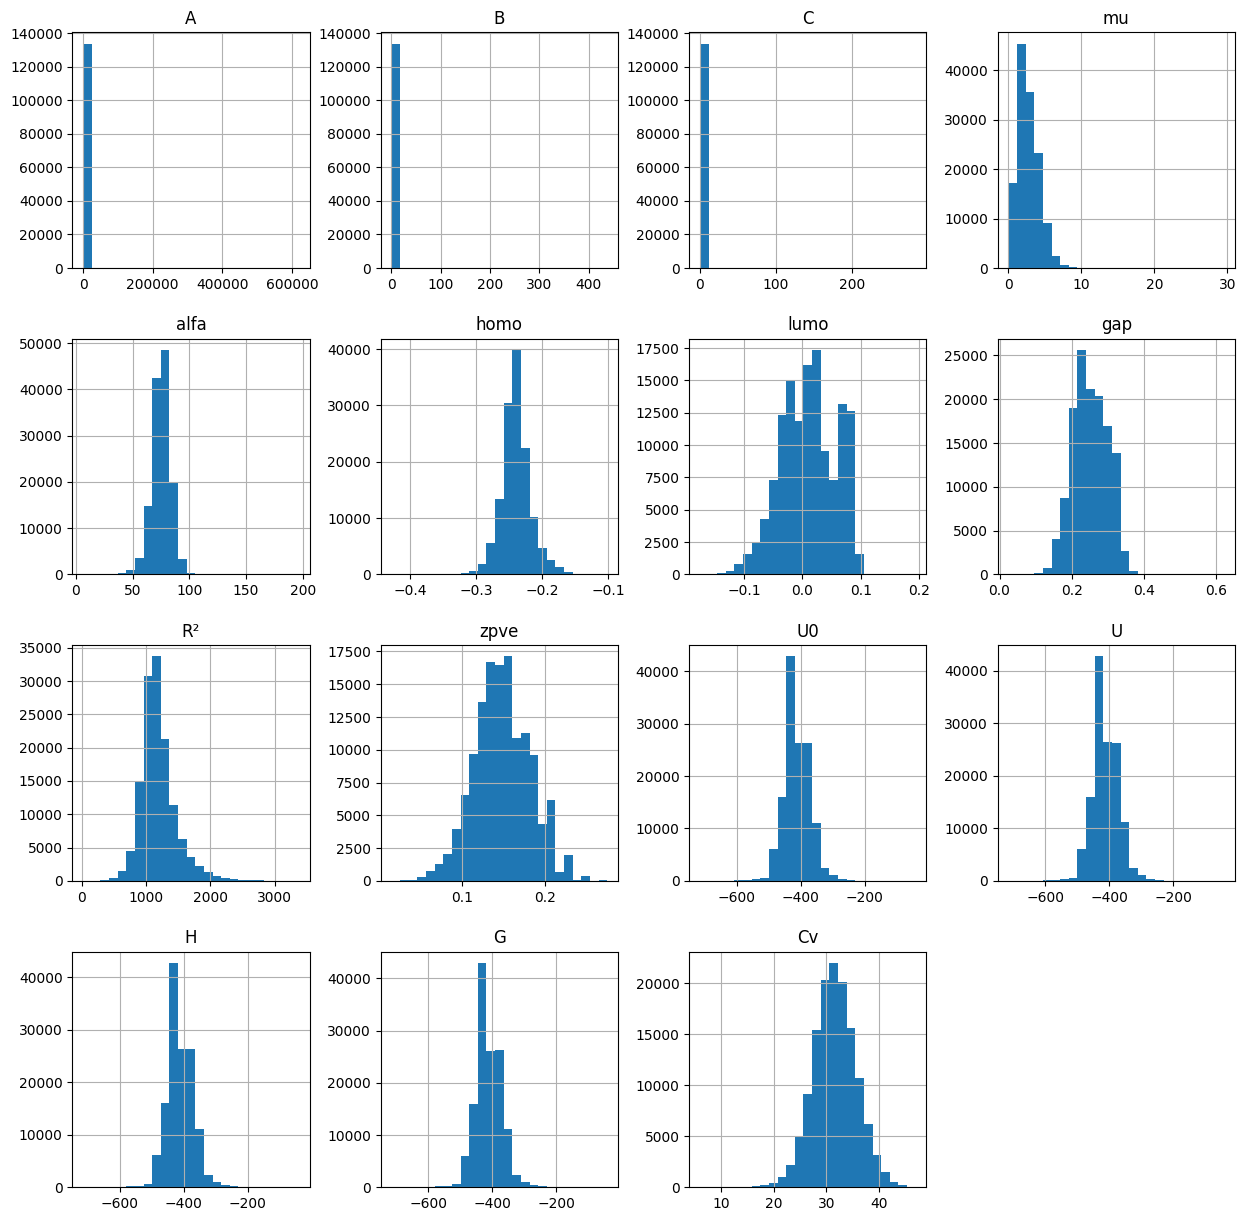

In [34]:
if read_and_write_xyz:
    targets = df[properties_names]
    
    # plot histograms of values in each column
    ax = plt.figure(figsize=(15, 15))
    hist = targets.hist(bins=25, ax=ax)
    ax.savefig('targets_before_scaling.png', dpi=300, bbox_inches='tight')
    ax.show()

In [ ]:
if read_and_write_xyz:
    # write the raw data to csv
    df.to_csv('../data/smiles_and_targets_raw.csv', index=False)
    df_scaled = df.copy()
    
    # drop outliers
    large_indices_A = df_scaled[df_scaled['A'] > 10].index
    print("Outliers in A:", len(large_indices_A))
    large_indices_B = df_scaled[df_scaled['B'] > 5].index
    print("Outliers in B:", len(large_indices_B))
    large_indices_C = df_scaled[df_scaled['C'] > 5].index
    print("Outliers in C:", len(large_indices_C))
    large_indices_mu = df_scaled[df_scaled['mu'] > 10].index
    print("Outliers in mu:", len(large_indices_mu))
    large_indices_temp1 = np.union1d(large_indices_A, large_indices_B)
    large_indices_temp2 = np.union1d(large_indices_C, large_indices_mu)
    large_indices = np.union1d(large_indices_temp1, large_indices_temp2)
    print("Total unique outliers:", len(large_indices))

    df_scaled = df_scaled.drop(large_indices)
    print("Number of samples in final dataset:", len(df_scaled))

In [ ]:
if read_and_write_xyz:
    df_scaled.describe() 

In [ ]:
if read_and_write_xyz:
    targets = df[properties_names]
    
    # plot histograms of values in each column
    ax = plt.figure(figsize=(15, 15))
    hist = targets.hist(bins=25, ax=ax)
    ax.savefig('targets_before_scaling.png', dpi=300, bbox_inches='tight')
    ax.show()

Write dataframe with scaled values to csv file

In [ ]:
if read_and_write_xyz:
    df_scaled.to_csv("../data/smiles_and_targets.csv")
else:
    df_scaled = pd.read_csv("../data/smiles_and_targets.csv")

### Molecular descriptors

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

if read_and_write_rdkit_descriptors:
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

    mol_descriptors = np.zeros(shape=(len(df_scaled), len([x[0] for x in Descriptors._descList])))

    counter = -1
    for molecule in df_scaled.smiles.values:
        counter += 1
        if counter % 1000 == 0:
            print("Iteration: ", counter)
        mol_descriptors[counter,:] = calc.CalcDescriptors(Chem.MolFromSmiles(molecule))

    print(df_scaled.smiles.values[1000])
    print(mol_descriptors[1000,:])
    descriptors_list = [x[0] for x in Descriptors._descList]
    print(descriptors_list)

Investigate descriptors

In [ ]:
if read_and_write_rdkit_descriptors:
    df_mol_descriptors = pd.DataFrame(mol_descriptors)
    print("Shape of mol_descriptors:", np.shape(df_mol_descriptors))
    df_mol_descriptors.describe()

In [ ]:
if read_and_write_rdkit_descriptors:
    df_mol_descriptors.describe().loc['std'].sort_values(ascending=False)

Remove descriptors where std. dev is zero

In [ ]:
if read_and_write_rdkit_descriptors:
    col_info = df_mol_descriptors.describe().loc['std']
    zero_std_cols = col_info[col_info == 0].index

    df_mol_descriptors = df_mol_descriptors.drop(zero_std_cols, axis=1)

    mol_descriptors = df_mol_descriptors.to_numpy()
    print("Shape of mol_descriptors after dropping columns with zero std.dev:", np.shape(mol_descriptors))

Save descriptors to file

In [ ]:
if read_and_write_rdkit_descriptors:
    np.save("../data/mol_descriptors.npy", mol_descriptors)
else:
    mol_rdkit_descriptors = np.load("../data/mol_descriptors.npy")

### Mordred descriptors

In [ ]:
from mordred import Calculator, descriptors

if read_and_write_mordred_descriptors:
    calc = Calculator(descriptors, ignore_3D=True)

    mol_descriptors = np.zeros(shape=(len(df_scaled), len(calc.descriptors)))

    counter = -1
    for molecule in df_scaled.smiles.values:
        counter += 1
        if counter % 1000 == 0:
            print("Iteration: ", counter)
        mol_descriptors[counter,:] = calc(Chem.MolFromSmiles(molecule))

    print(df_scaled.smiles.values[1000])
    print(mol_descriptors[1000,:])
    descriptors_list = [x[0] for x in Descriptors._descList]
    print(descriptors_list)

Iteration:  0
Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000


Investigate descriptors

In [ ]:
if read_and_write_mordred_descriptors:
    df_mol_descriptors = pd.DataFrame(mol_descriptors)
    print("Shape of mol_descriptors:", np.shape(df_mol_descriptors))
    df_mol_descriptors.describe()

Shape of mol_descriptors: (132820, 1613)


,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
count,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,...,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000,132820.000000
mean,6.735972,6.847627,0.015721,0.326984,10.917307,2.436739,4.638144,10.917307,1.239390,3.168396,...,9.286528,51.493736,122.816519,6.989967,80.649556,8.266451,46.556738,56.353847,3.369080,1.982333
std,0.727112,0.717053,0.144445,0.607757,0.925713,0.235529,0.386182,0.925713,0.075483,0.132125,...,0.843958,10.298563,7.154271,1.148384,13.490274,1.676465,9.598229,17.181715,0.881233,0.210510
min,2.121320,2.340100,0.000000,0.000000,4.000000,1.618034,3.236068,4.000000,0.800000,2.155909,...,5.509388,22.328143,50.015650,4.240818,10.000000,0.000000,10.000000,8.000000,0.888889,1.000000
25%,6.363961,6.371088,0.000000,0.000000,10.472136,2.246980,4.354483,10.472136,1.192231,3.093038,...,8.635687,40.201478,122.022861,6.254203,75.000000,7.000000,40.000000,44.000000,2.673611,1.833333
50%,6.651690,6.817889,0.000000,0.000000,11.014901,2.414214,4.573236,11.014901,1.240597,3.165884,...,9.247347,53.765429,125.047678,6.837134,82.000000,8.000000,46.000000,53.000000,3.284722,2.000000
75%,7.168527,7.357998,0.000000,1.000000,11.481605,2.619137,4.913497,11.481605,1.288360,3.261450,...,9.936003,60.467132,127.063329,7.565798,88.000000,9.000000,52.000000,67.000000,4.083333,2.138889
max,8.802517,8.986688,3.000000,5.000000,13.875004,3.170086,6.090950,13.875004,1.541667,3.603798,...,11.829975,71.467221,152.006069,17.248802,120.000000,13.000000,80.000000,124.000000,6.375000,2.500000


In [ ]:
if read_and_write_mordred_descriptors:
    df_mol_descriptors.describe().loc['std'].sort_values(ascending=False)

123     2326.593630
124     2012.301079
122     1836.680328
125     1482.071068
77      1393.626711
           ...     
339        0.006295
338        0.006166
1381       0.002381
1388       0.001403
1145       0.000054
Name: std, Length: 1311, dtype: float64

Remove descriptors where std. dev is zero

In [ ]:
if read_and_write_mordred_descriptors:
    col_info = df_mol_descriptors.describe().loc['std']
    zero_std_cols = col_info[col_info == 0].index

    df_mol_descriptors = df_mol_descriptors.drop(zero_std_cols, axis=1)

    mol_descriptors = df_mol_descriptors.to_numpy()
    print("Shape of mol_descriptors after dropping columns with zero std.dev:", np.shape(mol_descriptors))

Shape of mol_descriptors after dropping columns with zero std.dev: (132820, 1425)


Remove where std.dev is NaN

In [ ]:
if read_and_write_mordred_descriptors:
    # Reset index
    df_mol_descriptors.columns = range(0,len(df_mol_descriptors.columns))

    col_info = df_mol_descriptors.describe().loc['std']
    NaN_std_cols=np.argwhere(np.isnan(col_info.to_numpy()))
    NaN_std_cols = [int(i) for i in NaN_std_cols]

    df_mol_descriptors = df_mol_descriptors.drop(NaN_std_cols, axis=1)

    # Remove any columns/features that have nan elements
    df_mol_descriptors = df_mol_descriptors.dropna(axis=1)

    mol_descriptors = df_mol_descriptors.to_numpy()
    print("Shape of mol_descriptors after dropping columns with zero std.dev:", np.shape(mol_descriptors))

Shape of mol_descriptors after dropping columns with zero std.dev: (132820, 987)


Save descriptor

In [ ]:
if read_and_write_mordred_descriptors:
    np.save("../data/Mordred_mol_descriptors.npy", mol_descriptors)
else:
    mol_mordred_descriptors = np.load("../data/Mordred_mol_descriptors.npy")

### Morgan Fingerprints

Generate fingerprints

In [ ]:
from rdkit.Chem import AllChem
from rdkit.DataStructs import cDataStructs

if read_and_write_morgan_fingerprints:
    n_features = 1024*2 # Number of features
    radius = 2 # How far from current atom one can go to define a feature

    mol_fingerprint = np.zeros(shape=(len(df_scaled), n_features))

    key_list = []

    counter = -1
    for smile in df.smiles:
        counter += 1

        mol = Chem.MolFromSmiles(smile) # Convert to molecule
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=n_features) # Calculate morgan fingerprint that includes counts
        fp_dict = cDataStructs.UIntSparseIntVect.GetNonzeroElements(fp) # Get all non-zero elements to a dictionary
        arr = np.zeros((n_features,)) # A vector that will be the morgan fingerprint
        for key, val in fp_dict.items():
            key_list.append(int(key))
            arr[key] = val

        mol_fingerprint[counter] = arr


In [ ]:
if read_and_write_morgan_fingerprints:
    print(len(np.unique(key_list))) # Check for redundance (So we don't have features that are never used)

2048


Check min number of occurenses of any feature in fingerprint

In [ ]:
if read_and_write_morgan_fingerprints:
    mol_fingerprint[mol_fingerprint!=0] = 1 # Convert non-zero elements into ones

    mol_fingerprint_feature_occurence = np.sum(mol_fingerprint,axis=0)

    print(len(mol_fingerprint_feature_occurence))
    print("Min number of occurenses of any feature: ", np.min(mol_fingerprint_feature_occurence))
    print("Max number of occurenses of any feature: ", np.max(mol_fingerprint_feature_occurence))

2048
Min number of occurenses of any feature:  163.0
Max number of occurenses of any feature:  87155.0


Save fingerprints

In [ ]:
if read_and_write_morgan_fingerprints:
    np.save("../data/mol_morgan_fingerprints.npy", mol_fingerprint)
else:
    mol_morgan_fingerprints = np.load("../data/mol_morgan_fingerprints.npy")